# Where's Waldo

A project by Group #02:
* António Martins (20211369)
* Clara Barreto (20211768)
* Larissa Cayres de Lucia (20211138)
* Lúcio Roque do Rosário (20180830)
* Margarida Tedim (20201358)

## Object Detection

Just for fun

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance

In [ ]:
# Download extra waldo images from github
!wget --no-check-certificate \
    "https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldoprofessors.zip" \
    -O "/content/waldoprofessors.zip"

--2023-01-12 12:33:01--  https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldoprofessors.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldoprofessors.zip [following]
--2023-01-12 12:33:01--  https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldoprofessors.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555903 (543K) [application/zip]
Saving to: ‘/content/waldoprofessors.zip’

/content/waldoprofe 100%[===================>] 542.87K  --.-KB/s    in 0.006s  

2023-01-12 12:33:01 (85.1 MB/s) - ‘/content/wal

In [ ]:
zip_ref = zipfile.ZipFile('/content/waldoprofessors.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/waldo_professors') #Extracts the files into the /content folder
zip_ref.close()

In [ ]:
#get the images directory
#image_dir = os.getcwd() + '\\images\\finding_waldo'
image_dir = '/content/waldo_professors'

#get the background and waldo image directory
background_dir = image_dir + '/background.jpg'
illya_dir = image_dir + '/w_Illya.png'
mafalda_dir = image_dir + '/w_Mafalda.png'

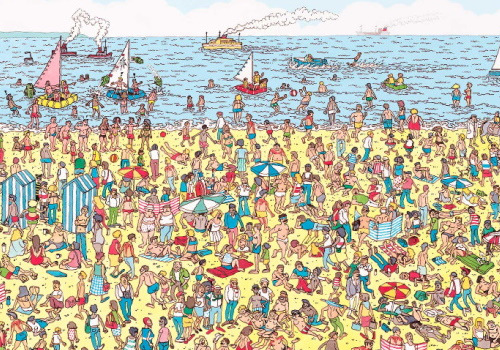

In [ ]:
#background image
background_im = Image.open(background_dir)
background_im

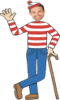

In [ ]:
#image of waldo
illya_im = Image.open(illya_dir)
illya_im = illya_im.resize((60, 100))
illya_im

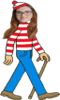

In [ ]:
#wilma
mafalda_im = Image.open(mafalda_dir)
mafalda_im = mafalda_im.resize((60, 100))
mafalda_im

In [ ]:
#create a function to generate images
def generate_sample_image():
    
    #background image
    background_im = Image.open(background_dir)
    background_im = background_im.resize((500, 350))
    #background_im = Image.new("RGB", (500, 350), (255, 255, 255))

    #waldo
    illya_im = Image.open(illya_dir)
    illya_im = illya_im.resize((60, 100))

    #wilma
    mafalda_im = Image.open(mafalda_dir)
    mafalda_im = mafalda_im.resize((60, 100))
    
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    #pic randomly between waldo and wilma. If 1 we will select waldo. if 0 we wills elect wilma
    rand_person = np.random.choice([0, 1], p = [0.5, 0.5])
    
    if rand_person == 1:
        
        background_im.paste(illya_im, (col, row), mask = illya_im)
        cat = 'Illya'
        
    else:
        
        background_im.paste(mafalda_im, (col, row), mask = mafalda_im)
        cat = 'Mafalda'
        
    return np.array(background_im).astype('uint8'), (col, row), rand_person, cat 

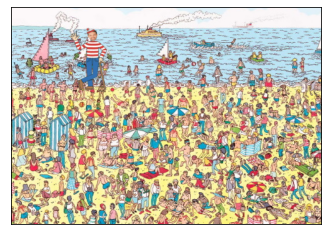

In [ ]:
#generate the sample image and plot
sample_im, pos, _, cat = generate_sample_image()
plt.imshow(sample_im)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords = None):
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

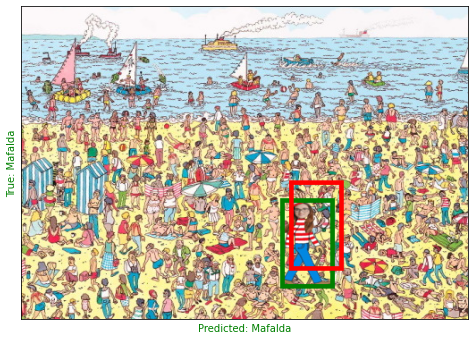

In [ ]:
#generate an example image
sample_im, pos, _, cat = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted: ' + cat, color = 'green')
plt.ylabel('True: ' + cat, color = 'green' )
plt.show()

In [ ]:
#data generator function 
def generate_data(batch_size = 16):
    
    while True:
        
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
        
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos, person, _ = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        yield x_batch , {'class': y_batch, 'box': boundary_box}

In [ ]:
#create the model
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

def classification_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)
    
    return x

In [ ]:
#create the model instance
inputs = tf.keras.Input((350, 500, 3))

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)
class_output = classification_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])

In [ ]:
#custom function to visualize the predictions after epochs
def test_model():
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))    
    
    for i in range(3):
        
        #get sample image
        sample_im, pos, _, cat = generate_sample_image()
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
        predicted_class, predicted_box = model.predict(sample_image_normalized)
        
        if predicted_class > 0.5:
            predicted_class = 'Illya'
        else:
            predicted_class = 'Mafalda'
        
        #assign color
        col = 'green' if (predicted_class == cat) else 'red'
        
        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))
        
        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + cat, color = 'green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color = col)
        
    plt.show()
        
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model()
            
#learning rate scheduleer
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

In [ ]:
#compile
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy', 'box': 'mse'})

Epoch 1/10
1/1 [==============================] - 0s 21ms/step


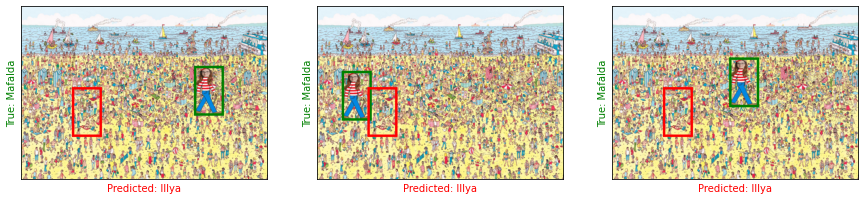

100/100 [==============================] - 52s 422ms/step - loss: 2688.7017 - class_loss: 2.8446 - box_loss: 2685.8562 - class_accuracy: 0.5369 - box_mse: 2685.8562 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 41s 417ms/step - loss: 70.1307 - class_loss: 0.6777 - box_loss: 69.4529 - class_accuracy: 0.6438 - box_mse: 69.4529 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 19ms/step


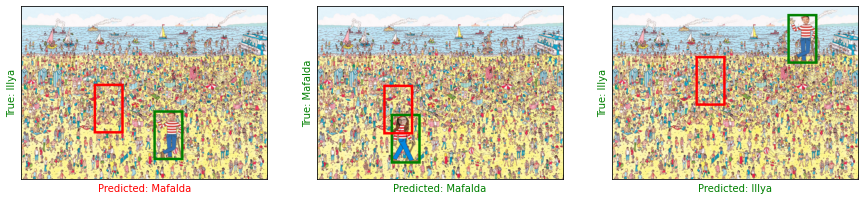

100/100 [==============================] - 42s 421ms/step - loss: 73.7161 - class_loss: 0.5899 - box_loss: 73.1261 - class_accuracy: 0.7281 - box_mse: 73.1261 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 41s 416ms/step - loss: 55.4849 - class_loss: 0.4742 - box_loss: 55.0107 - class_accuracy: 0.8062 - box_mse: 55.0107 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 19ms/step


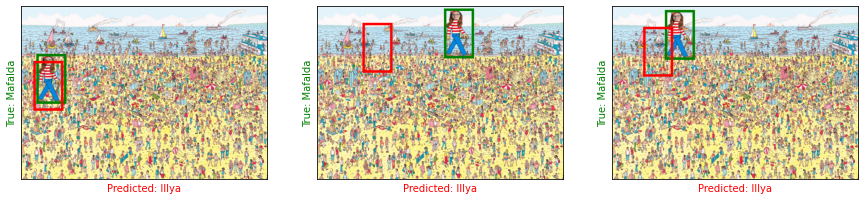

100/100 [==============================] - 42s 422ms/step - loss: 22.8925 - class_loss: 0.0914 - box_loss: 22.8010 - class_accuracy: 0.9800 - box_mse: 22.8010 - lr: 2.0000e-04
Epoch 6/10
100/100 [==============================] - 41s 417ms/step - loss: 11.5512 - class_loss: 0.0388 - box_loss: 11.5124 - class_accuracy: 0.9962 - box_mse: 11.5124 - lr: 2.0000e-04
Epoch 7/10
1/1 [==============================] - 0s 19ms/step


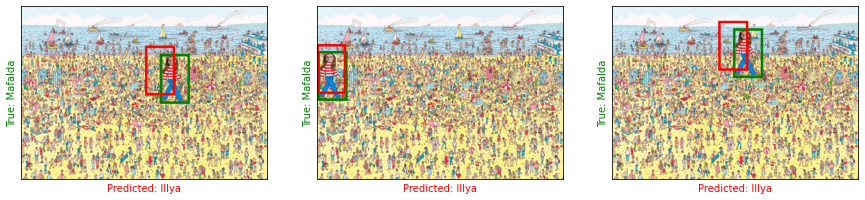

100/100 [==============================] - 42s 420ms/step - loss: 10.2710 - class_loss: 0.0241 - box_loss: 10.2469 - class_accuracy: 0.9981 - box_mse: 10.2469 - lr: 2.0000e-04
Epoch 8/10
100/100 [==============================] - 42s 421ms/step - loss: 11.1081 - class_loss: 0.0175 - box_loss: 11.0906 - class_accuracy: 0.9969 - box_mse: 11.0906 - lr: 2.0000e-04
Epoch 9/10
1/1 [==============================] - 0s 19ms/step


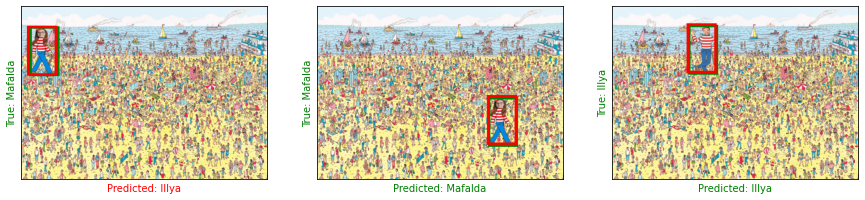

100/100 [==============================] - 42s 423ms/step - loss: 9.5915 - class_loss: 0.0136 - box_loss: 9.5779 - class_accuracy: 0.9981 - box_mse: 9.5779 - lr: 2.0000e-04
Epoch 10/10
100/100 [==============================] - 41s 418ms/step - loss: 6.8301 - class_loss: 0.0102 - box_loss: 6.8198 - class_accuracy: 1.0000 - box_mse: 6.8198 - lr: 4.0000e-05


In [ ]:
#beginning time
tick = time.time()

#fit the model
hist = model.fit(generate_data(), epochs = 10, steps_per_epoch = 100, callbacks = [VisCallback(),\
                                                                           tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()

In [ ]:
#print time taken 
print('Took {} minutes to run finish training 10 epochs'.format(np.round((tock - tick)/60, 2)))

Took 7.15 minutes to run finish training 10 epochs


1/1 [==============================] - 0s 18ms/step


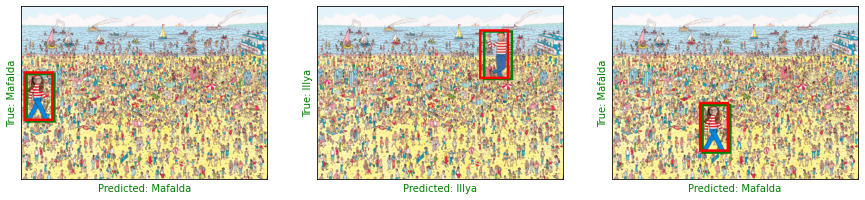

1/1 [==============================] - 0s 18ms/step


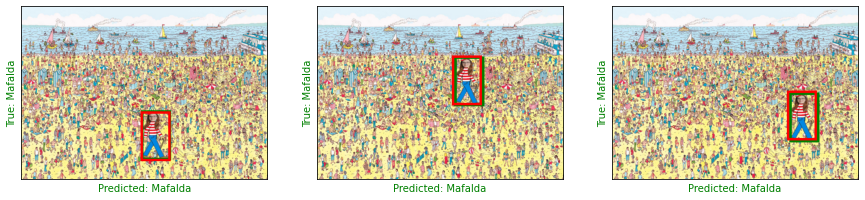

1/1 [==============================] - 0s 19ms/step


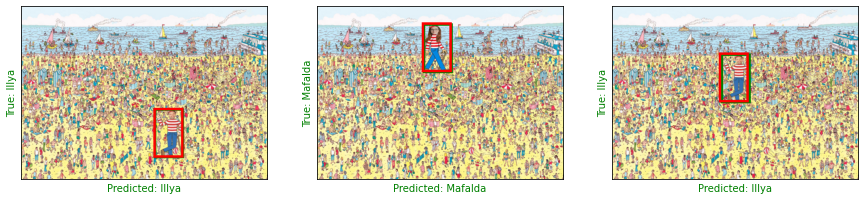

1/1 [==============================] - 0s 19ms/step


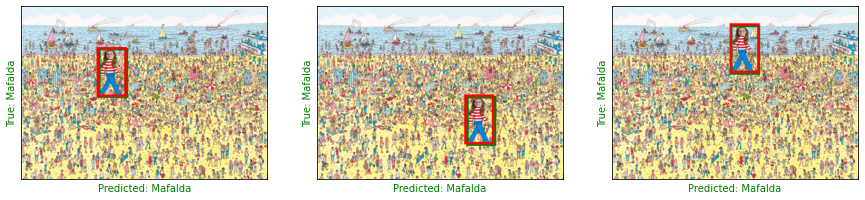

1/1 [==============================] - 0s 18ms/step


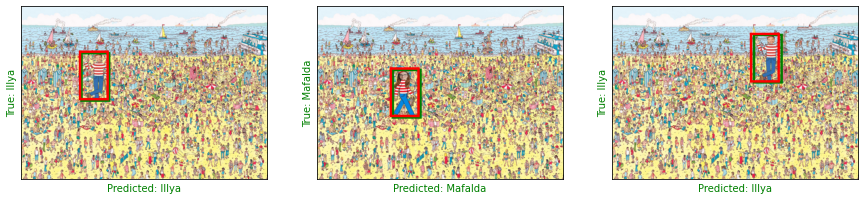

1/1 [==============================] - 0s 18ms/step


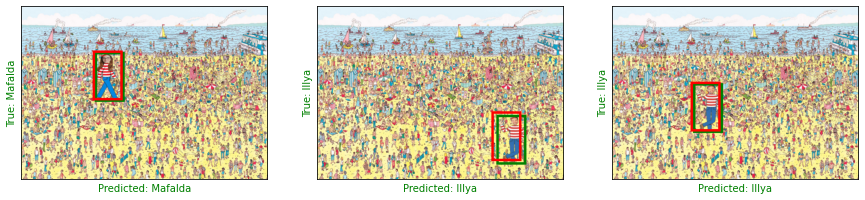

1/1 [==============================] - 0s 17ms/step


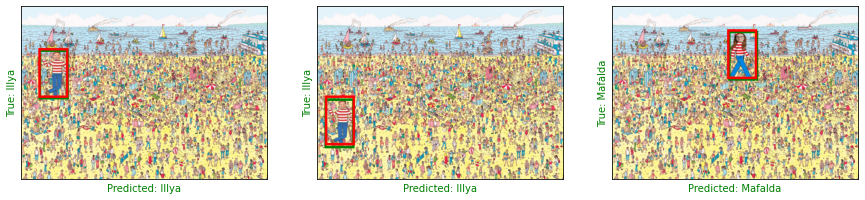

1/1 [==============================] - 0s 18ms/step


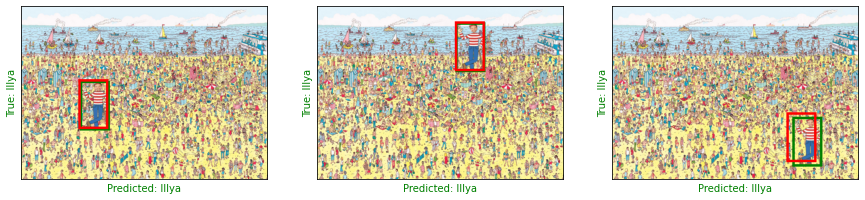

1/1 [==============================] - 0s 17ms/step


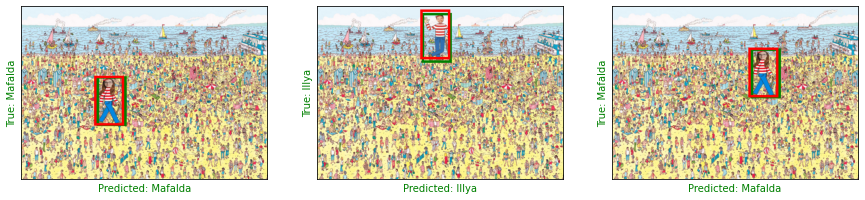

1/1 [==============================] - 0s 19ms/step


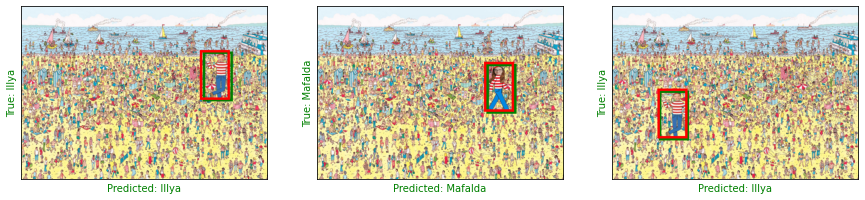

In [ ]:
#test again in the end a couple of times
for i in range(10):
    test_model()